In [13]:
import math
import os
from glob import glob
from itertools import combinations
from urllib.error import URLError

import earthpy as et
import earthpy.appeears as etapp
import geopandas as gpd
import holoviews as hv
import hvplot as hv
import hvplot.pandas
import hvplot.xarray
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import rasterio
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from IPython.display import Image
import utm
import xarray as xr
import xrspatial
import warnings
import zipfile

from pyproj import CRS
from pyproj import Transformer
from scipy.interpolate import griddata
from shapely.geometry import Polygon

In [4]:
# Set up directory
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME)
# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

las_index_path = os.path.join(
    data_dir,
    'earthpy-downloads',
    'lidar_index_cspn_q2',
    'lidar_index_cspn_q2.shp'
)

# Download LIDAR index tiles
if not os.path.exists(las_index_path):
    las_index_url = ('https://gisdata.drcog.org:8443/geoserver/DRCOGPUB/'
             'ows?service=WFS&version=1.0.0&request=GetFeature&'
             'typeName=DRCOGPUB:lidar_index_cspn_q2&outputFormat=SHAPE-ZIP')

    las_index_shp = et.data.get_data(url=las_index_url)

las_index_gdf = (
    gpd.read_file(las_index_path).set_index('tile')
    .loc[['N3W345']]
)

las_index_gdf = las_index_gdf.to_crs('EPSG:4269')

# # Define the target CRS (EPSG 6428)
# target_crs = CRS.from_epsg(6428)
# #target_crs = target_crs.to_proj4()

# Define the transformer to convert from EPSG 4326 to EPSG 6428

# Update the GeoDataFrame CRS
# las_gdf_reprojected = las_index_gdf.to_crs(target_crs)

las_index_gdf.hvplot(
    tiles = 'OSM',
    geo = True,
    line_color='black',
    line_width=2,
    fill_alpha=0
)


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [5]:
# Download test DRAPP tile and use it to find overlapping LAS files

test_tile_path = os.path.join(
    data_dir,
    'earthpy-downloads',
    'N3W345.tif'
)

if not os.path.exists(test_tile_path):
    test_tile_url = 'https://drapparchive.s3.amazonaws.com/2020/N3W345.tif'
    et.data.get_data(url=test_tile_url)
    
test_aerial = rxr.open_rasterio(test_tile_path)

#test_aerial = test_aerial.rio.reproject(las_index_gdf.crs)

#aerial_bounds = test_aerial.rio.bounds()

test_aerial_plot = test_aerial.hvplot.rgb(rasterize=True, aspect='equal', x = 'x', y = 'y')
test_aerial_plot

:DynamicMap   []
   :RGB   [x,y]   (R,G,B)

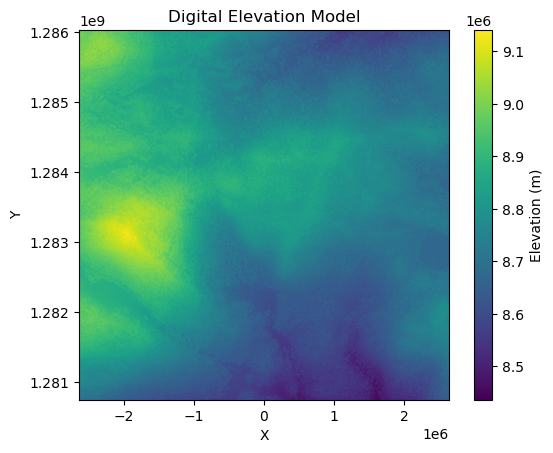

In [26]:
# Download and process LAS file
las_path = os.path.join(
    data_dir,
    'earthpy-downloads',
    'N3W345.las'
)

if not os.path.exists(test_tile_path):
    las_url = 'https://lidararchive.s3.amazonaws.com/2020_CSPN_Q2/N3W345.las'
    et.data.get_data(url=las_url)

in_las = laspy.read(las_path)

first_returns = in_las.points[in_las.return_num == 1]

# Randomly sample a fraction of the points (adjust sample_fraction as needed)
sample_fraction = 0.1  # 10% of the points
sample_indices = np.random.choice(range(len(first_returns)), size=int(len(first_returns) * sample_fraction), replace=False)
x = first_returns['X'][sample_indices]
y = first_returns['Y'][sample_indices]
z = first_returns['Z'][sample_indices]

# Define grid resolution
grid_resolution = 100  # Adjust as needed
grid_downsample_factor = 100  # Adjust as needed

# Downsample the grid
x_grid = np.arange(min(x), max(x), grid_resolution)
y_grid = np.arange(min(y), max(y), grid_resolution)
x_grid_downsampled = x_grid[::grid_downsample_factor]
y_grid_downsampled = y_grid[::grid_downsample_factor]
xx, yy = np.meshgrid(x_grid_downsampled, y_grid_downsampled)

# Interpolate elevation values onto the downsampled grid
zi = griddata((x, y), z, (xx, yy), method='linear')

# Visualize the DEM
plt.imshow(zi, extent=(min(x), max(x), min(y), max(y)))
plt.colorbar(label='Elevation (m)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Digital Elevation Model')
plt.show()
# dem_array = rxr.open_rasterio(zi)

# dem_array.hvplot(rasterize=True,
#         aspect='equal')

In [24]:
zi

array([[             nan,              nan,              nan, ...,
                     nan,              nan,              nan],
       [             nan, 8985180.73731091, 8976961.93275954, ...,
        8593232.37504447, 8589669.5347719 , 8588940.78135665],
       [             nan, 8976263.73162058, 8974864.44846053, ...,
        8594226.4447157 , 8594419.78991093, 8609083.2053303 ],
       ...,
       [             nan, 8719373.83354811, 8717865.37940087, ...,
        8630693.02764268, 8632962.86862415, 8640689.70103757],
       [             nan, 8699329.73900438, 8702684.79541571, ...,
        8650242.36706651, 8644775.24677448, 8638761.42101648],
       [             nan, 8712566.47041723, 8713338.33382489, ...,
        8659922.91673699, 8643359.288559  , 8636824.37891431]])

array([             nan, 8985180.73731091, 8976961.93275954,
       8996091.82089449, 8992022.63567113, 8972396.04167422,
       8986336.23539342, 8973451.40979139, 8981671.70491117,
       8972944.66148028, 8989718.74145587, 8995747.25961831,
       8972747.07615197, 8994800.24933551, 8966870.76693198,
       8966846.80634496, 8967143.53312833, 8984837.92976563,
       8967821.26191501, 8968948.39405505, 8985964.55561512,
       8970604.31818472, 8973518.42607265, 8971209.82289295,
       8982177.19366256, 9009393.0628255 , 9005135.18357848,
       8983059.75277004, 8989892.85195775, 8977974.23240262,
       9000507.53741857, 9003329.56346938, 8983491.78626605,
       8978712.29400145, 8991586.74670328, 9004517.27238671,
       8983509.59272031, 8973892.61282366, 8971722.17800421,
       8969790.65679774, 8971873.5197549 , 8970409.619518  ,
       8977569.67214687, 8969349.23021919, 8962471.91826349,
       8966439.08389493, 8990513.69938573, 8967368.02941959,
       8955681.63329637,